## Big Data & Society Problem Set 3

### Problem Set 3 - Extend What You Have Learned

Now that you know how to scrape data from Twitter, let's extend the exercise a little so you can show us what you know. This time you will set up the scraper to get data around MIT and scrape data for 20 minutes. Then you will visualize it with and visualize. Think about what you would need to change to do that.

Once you have the new JSON file of Boston tweets you should a pie chart and scatterplot of your collected tweets. When you are creating your dataset, you should get at least two different attributes returned by the Twitter API (we got many of them above, so base it off of that example). Atleast one of them should be the tweet id. Make sure you remove and duplicate tweets (if any). Expanding on the above, then save the data to a CSV.

Make sure you get your own Twitter Key.

#### Deliverables
***1*** - Using the Twitter REST API, collect Tweets from Boston for 20 min. Note how you set the time in the above example (in the ***run_all()*** function), it was in seconds. How would you do that here?

***2*** - Create a Pie Chart showing a summary of tweets by user location. Please clean up the data so that multiple variations of the same location name are replaced with one variation.

***3*** - Create a Scatterplot showing all of the tweets that had a latitude and longitude.

***4*** - Pick a search term, such as Trump or #Trump and collect 15 minutes of tweets on it. Use the same lat/lon for Boston as you used above.

***5*** - Export the entirety of your scraped Twitter datasets (one with a search term, one without) to two CSV files. We will be checking this CSV file for duplicates. So clean your file.

#### What to Give Us on Stellar
***1*** - Create a new Jupyter notebook that contains your scraper code. You can copy much of this one, but customize it. Submit the new Jupyter notebook, which includes your pie chart and scatterplot.

***2*** - Your final CSV files.

In [3]:
# import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# import my twitter keys from the python file
from twitter_key_LOCAL import api_key, api_secret

In [2]:
# assign the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

### Deliverable 1: Scrape Twitter Data

In [15]:
# QUERY TWITTER TO GET TWEETS AT MIT

# Input the search term you want to search on
search_term='' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[42.360091,-71.096354] # MIT Campus, Cambridge, MA
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=15


# fetch tweets with a given query at a given lat-long
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Thu Mar 02 14:42:08 +0000 2017',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [{'display_url': 'twitter.com/i/web/status/8…',
     'expanded_url': 'https://twitter.com/i/web/status/837312068252495872',
     'indices': [116, 139],
     'url': 'https://t.co/vcqxov0VwE'}],
   'user_mentions': [{'id': 15280868,
     'id_str': '15280868',
     'indices': [51, 56],
     'name': 'TalesOfTheCocktail',
     'screen_name': 'totc'}]},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 837312068252495872,
  'id_str': '837312068252495872',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': True,
  'lang': 'en',
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'place': None,
  'possibly_sensitive': False,
  'quoted_status': {'contributors': None,

In [16]:
## Automate the API

# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 1200
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 30
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

In [17]:
## Run the Twitter scraper

# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 15 new tweets, for a total of 15
At 30 seconds, added 14 new tweets, for a total of 29
At 60 seconds, added 13 new tweets, for a total of 42
At 90 seconds, added 15 new tweets, for a total of 57
At 120 seconds, added 15 new tweets, for a total of 72
At 150 seconds, added 15 new tweets, for a total of 87
At 180 seconds, added 15 new tweets, for a total of 102
At 210 seconds, added 15 new tweets, for a total of 117
At 240 seconds, added 15 new tweets, for a total of 132
At 270 seconds, added 15 new tweets, for a total of 147
At 300 seconds, added 15 new tweets, for a total of 162
At 330 seconds, added 15 new tweets, for a total of 177
At 360 seconds, added 15 new tweets, for a total of 192
At 390 seconds, added 15 new tweets, for a total of 207
At 420 seconds, added 15 new tweets, for a total of 222
At 450 seconds, added 15 new tweets, for a total of 237
At 480 seconds, added 15 new tweets, for a total of 252
At 510 seconds, added 15 new tweets, for a total of 267
At 

In [8]:
## Explore the data

# import additional libraries to plot and interact with the operating system
from os import listdir ## allows us to get files from our computers
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Get the file names from a given directory
file_dir = "data" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                
df_tweets

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
837313174005301248,837313174005301248,None,None,@MuseumThoughts I am considering buying a new ...,"Cambridge, MA",610020274,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313173514506245,837313173514506245,None,None,RT @NEnberg: Great @NECN interview w/ @TheReal...,"Boston, MA",52715613,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313171388006401,837313171388006401,None,None,"RT @khalifallah: My advice to @SenJohnMcCain ,...","Dublin, Ireland.",26847410,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170981150725,837313170981150725,None,None,Nobody should come at me talking about Hillary...,"Boston, MA",3081610787,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170268127232,837313170268127232,None,None,"Daily KHL Update - March 1st, 2017 (English) h...","Boston, MA",836616223840481280,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313170058457088,837313170058457088,None,None,@MichaelOkinczyc @washingtonpost recusal not e...,"Boston, MA",526442007,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169907412992,837313169907412992,None,None,"RT @LibroFilosofico: Digan lo que digan, para ...",sevilla,2904410428,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169903218688,837313169903218688,None,None,"RT @dabeard: ""In America...no one is above the...",,759407987152736258,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169437552641,837313169437552641,None,None,RT @etambascio: They knew #Sessions was immora...,West Hills,12146652,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313168707833856,837313168707833856,None,None,"Sadly, recent threats to Jewish community cent...","Boston, MA",20396001,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017


### Deliverable 2: Clean the Data & Display in a Pie Chart

In [10]:
## Clean the data so that duplicates are dropped and locations are consistently titled
df_tweets = df_tweets.astype(str)

In [11]:
df_tweets.duplicated()

837313174005301248    False
837313173514506245    False
837313171388006401    False
837313170981150725    False
837313170268127232    False
837313170058457088    False
837313169907412992    False
837313169903218688    False
837313169437552641    False
837313168707833856    False
837313168535871488    False
837313167055290369    False
837313166728122369    False
837313166581334016    False
837313166006693889    False
837313298886508544    False
837313298869661697    False
837313298840309760    False
837313298836107264    False
837313298689294336    False
837313297158406145    False
837313296122302465    False
837313296084652032    False
837313296084578305    False
837313295098896384    False
837313294524375040    False
837313293995888640    False
837313293584896001    False
837313293043793920    False
837313425961324544    False
                      ...  
837317981751377924    False
837317980677672960    False
837317979964588032    False
837317979847200768    False
837317979691864064  

In [12]:
df_tweets.drop_duplicates()

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
837313174005301248,837313174005301248,None,None,@MuseumThoughts I am considering buying a new ...,"Cambridge, MA",610020274,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313173514506245,837313173514506245,None,None,RT @NEnberg: Great @NECN interview w/ @TheReal...,"Boston, MA",52715613,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313171388006401,837313171388006401,None,None,"RT @khalifallah: My advice to @SenJohnMcCain ,...","Dublin, Ireland.",26847410,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170981150725,837313170981150725,None,None,Nobody should come at me talking about Hillary...,"Boston, MA",3081610787,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170268127232,837313170268127232,None,None,"Daily KHL Update - March 1st, 2017 (English) h...","Boston, MA",836616223840481280,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313170058457088,837313170058457088,None,None,@MichaelOkinczyc @washingtonpost recusal not e...,"Boston, MA",526442007,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169907412992,837313169907412992,None,None,"RT @LibroFilosofico: Digan lo que digan, para ...",sevilla,2904410428,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169903218688,837313169903218688,None,None,"RT @dabeard: ""In America...no one is above the...",,759407987152736258,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169437552641,837313169437552641,None,None,RT @etambascio: They knew #Sessions was immora...,West Hills,12146652,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313168707833856,837313168707833856,None,None,"Sadly, recent threats to Jewish community cent...","Boston, MA",20396001,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017


In [13]:
df_tweets['location'].unique()

array(['Cambridge, MA', 'Boston, MA', 'Dublin, Ireland.', 'sevilla', '',
       'West Hills', '✨✨', 'Illinois, USA', 'Seattle WA',
       ' 98 Rice St Boston, MA 02128', 'Somerville, MA', 'Boston',
       'Pembroke, MA', 'Lawrence/Mia-NYC tellys lol...', 'Lowell, MA',
       'dmv // boston ', 'Boston, MA ', 'Brockton,MA', 'Boston Ma', 'LTX',
       'Boston Ma ', 'Massachusetts, USA',
       '4 Yawkey Way, Boston, MA 02215', 'Brasil', 'Stoughton',
       'Framingham, MA', '#UNDERWATERSQUAD', 'Mostly Boston',
       'Stoneham, MA', 'Maryland ', 'Ithaca, NY', 'Medway', 'Miami Beach',
       'Los Angeles via Boston', 'Virginia, USA', 'Medford', 'Chicago, IL',
       'Weymouth', 'The Bebop', 'Arlington, MA', 'Boston, Massachusetts',
       'Boston MA', 'The Granite State ', 'Boston, Ma.', 'boston',
       'Quincy, MA', 'Everett, MA', 'Baton Rouge', 'Brockton, MA',
       'Medford, MA 02155', 'Norwell, MA', 'Boston Massachusetts',
       'France', 'Weymouth, MA', 'North Reading, MA', 'Boston

In [14]:
# groupping and sorting
grouped_tweets = df_tweets.groupby('location')
count_tweets = grouped_tweets['location'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location']
df_count_tweets.sort_index()

,Count
Location,
,75
"98 Rice St Boston, MA 02128",1
#KEN,1
#UNDERWATERSQUAD,1
02124,2
02149,1
"4 Yawkey Way, Boston, MA 02215",1
45-119 lil haiti gang shit,1
?,1


In [15]:
# List of variations of Boston
variations_of_boston = ['Boston, MA',' 98 Rice St Boston, MA 02128','Boston','dmv // boston ','Boston, MA ','Boston Ma',
       'Boston Ma ','4 Yawkey Way, Boston, MA 02215','Mostly Boston','Los Angeles via Boston','Boston, Massachusetts','Boston MA','Boston, Ma.','boston','Boston Massachusetts','Boston\r',
       'Boston, Massachusetts. ','BOSTON','Jamaica Plain, Boston','Beacon Hill, Boston, MA','Boston,MA','Boston, MA USA', 'Boston,Massachusetts','Lower Mills, Boston', 
       'NYC/Boston', '02124','Boston, Ma','boston, ma', 'Boston/Mattapan, MA','BOS','Fenway Park',
       'NYC/Boston  ','boston  ','Roxbury Boston','Boston. ','Boston, United States','Boston ',
       'South Boston, MA','VT ✈Amherst MA✈Boston', 'Greater Boston', "Newman University '20",
       'Allston, MA','02149','Chelsea','boston, massachusetts','Jamaica Plain, MA','Boston College','Boston Ma USA','Chelsea ','East Boston, MA']

variations_of_cambridge = ['Cambridge, MA','Cambridge, MA, USA','Harvard University','Cambridge, Massachusetts','cambridge, MA, USA','Kendall Square, Cambridge, MA']

# Renaming other locations into broader categories
other_MA_names = ['Somerville, MA','Pembroke, MA', 'Lawrence/Mia-NYC tellys lol...', 'Lowell, MA',
       'Brockton,MA','Massachusetts, USA','Stoughton',
       'Framingham, MA','Stoneham, MA','Medway','Medford','Weymouth','Arlington, MA','Quincy, MA', 'Everett, MA','Brockton, MA','Medford, MA 02155', 'Norwell, MA','Weymouth, MA', 'North Reading, MA', 'Cleveland, OH',
       'Malden, MA','Scituate, MA','Wilmington, MA', 'Revere, MA','Plymouth, MA','Ashland, MA','Hanover MA','Lawrence ma\n',
       'Hanover, MA', 'Quincy', 'Lynn, MA','Bedford, Massachusetts','Salem, MA', 'Weston, MA','Lawrence, MA', 'Norwood',
       'Chelmsford, MA','lawrence, Ma','Wellesley, MA',
       'weymouth','Beverly, MA','Framingham, Massachusetts', 'Medway, MA',
       'Needham, MA','Lynn,  Massachusetts ','Franklin, Massachusetts',
       'melrose, ma', 'Waltham, MA', 'Middleton, MA',
       'Belmont, MA','Newton, MA','Medfield, MA','Lexington, MA',
       'Danvers, MA', 'Kingston, MA','Hopkinton, Massachusetts',
       'Weymouth MA', 'Andover, Massachusetts', 'Massachusetts',
       'Lawrence MA','MA', 'Melrose', 'North Andover, MA']

other_US_locations = ['West Hills', 'Illinois, USA', 'Seattle WA','Maryland ',
       'Ithaca, NY','Miami Beach', 'Virginia, USA',
       'Chicago, IL','The Granite State ','Baton Rouge','Cleveland, OH',
       'Ocean City, MD','Dallas, TX', 'valencina',
       'Main St. USA', 'San Diego, CA',
       'Sureste del Astrodome, Tejas', 'Dorado, Puerto Rico', 'NY | ATL ',
       'Brooklyn, NY','Manhattan, NY','Washington, DC','NYC',
       'Somewhere, U.S.A.','Florida, USA',
       'San Jose, California, USA','El Salvador C.A.','North Bergen, NJ','CHI, IL & SF, CA',
       'New Orleans, Louisiana, U.S.A','Eureka Springs, Arkansas',
       'New York, NY','United States ',
       'Oklahoma City, OK','Nevada','West Covina, CA', 'Colorado, USA', 'Tampa, FL','St. Paul, MN',
       'north of Topeka, west a the 71','Dallas, Tx',
       'Rock Island, IL', 'CT ', 'University of Parris Island',
       'Vernon, CT', 'La Vista, NE',
       'NYC, LA & Orlando']

other_country_locations = ['Dublin, Ireland.', 'sevilla','Brasil','France',
       'Temerloh, Pahang', 'NW London.', 'Shenzhen China',
       'Zaragoza, Ciudad de Leones','Canada','Santiago del Estero, Argentina', 'Tungurahua, Ecuador',
       'South London', 'Cuenca, Ecuador','London/Accra','United Kingdom',
       'MS/La Trinchera, México D.F','Buenos Aires, Argentina',
       'Nairobi, Kenya','São Paulo', 'Santiago, Chile', 'Bucaramanga, Colombia',
       'Brisbane Queensland Australia', 'korea ', 'Vancouver, BC','Tübingen, Deutschland', 'Toronto | Vaughan',
       'El Colorado Formosa, Argentina','Ontario, Canada','Reynosa, Tamaulipas','Sequatchie Valley','Romford, Essex','Shenzhen, China']

other = ['', '✨✨','LTX','#UNDERWATERSQUAD', 'The Bebop', 'STEVE DRIVE ',
       'in a city near you ', 'h-e-double hockey sticks',
       '45-119 lil haiti gang shit', 'Acampamento Meio-Sangue ', '죽어있음',
       '#KEN ', '서울, 남원', 'memeland', 'the upside down', '?',
       'Space City ', 'Somewhere on planet Earth', 'd[m]v',
       'ig:peachymariii | sc:marielski', 'Oran                          ',
       'IG:walkoverme12', 'GSID3 All$In', "prolly mine or kevin's bed",
       'The Town Hall', "At World's End", 'Mercedes bs.as',
       'anywhere betw. N 55° and S 55°', 'Everywhere ','not dead but almost']
df_tweets1=df_tweets['location'].replace(variations_of_boston, 'Boston, MA').replace(variations_of_cambridge, 'Cambridge, MA').replace(other_MA_names, 'Other MA Locations').replace(other_US_locations, 'Other US Locations').replace(other_country_locations, 'Other Country Locations').replace(other, 'Other')
df_tweets1

837313174005301248              Cambridge, MA
837313173514506245                 Boston, MA
837313171388006401    Other Country Locations
837313170981150725                 Boston, MA
837313170268127232                 Boston, MA
837313170058457088                 Boston, MA
837313169907412992    Other Country Locations
837313169903218688                      Other
837313169437552641         Other US Locations
837313168707833856                 Boston, MA
837313168535871488                      Other
837313167055290369         Other US Locations
837313166728122369                 Boston, MA
837313166581334016         Other US Locations
837313166006693889                 Boston, MA
837313298886508544         Other MA Locations
837313298869661697                 Boston, MA
837313298840309760                 Boston, MA
837313298836107264                 Boston, MA
837313298689294336                 Boston, MA
837313297158406145                 Boston, MA
837313296122302465         Other M

In [16]:
df_tweets1.unique()

array(['Cambridge, MA', 'Boston, MA', 'Other Country Locations', 'Other',
       'Other US Locations', 'Other MA Locations'], dtype=object)

In [17]:
df_tweets2 = pd.DataFrame(df_tweets1)

In [18]:
# groupping and sorting
grouped_tweets = df_tweets2.groupby('location')
count_tweets = grouped_tweets['location'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location']
df_count_tweets.sort_index()

,Count
Location,
"Boston, MA",283
"Cambridge, MA",26
Other,104
Other Country Locations,42
Other MA Locations,91
Other US Locations,50


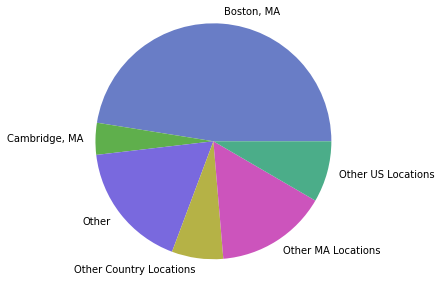

In [19]:
# create a list of colors (from iWantHue)
colors = ["#697dc6","#5faf4c","#7969de","#b5b246",
          "#cc54bc","#4bad89"]

# create a pie chart
plt.pie( df_count_tweets['Count'], labels=df_count_tweets.index.get_values(), shadow=False, colors=colors)

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

## ADD TITLE AND CHANGE COLORS!!

### Deliverable 3: Create a Scatterplot

In [21]:
# Create a filter from df_tweets2 filtering only those that have values for lat and lon
df_tweets_with_location = df_tweets[df_tweets.lon.notnull() & df_tweets.lat.notnull()]
df_tweets_with_location

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
837313174005301248,837313174005301248,None,None,@MuseumThoughts I am considering buying a new ...,"Cambridge, MA",610020274,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313173514506245,837313173514506245,None,None,RT @NEnberg: Great @NECN interview w/ @TheReal...,"Boston, MA",52715613,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313171388006401,837313171388006401,None,None,"RT @khalifallah: My advice to @SenJohnMcCain ,...","Dublin, Ireland.",26847410,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170981150725,837313170981150725,None,None,Nobody should come at me talking about Hillary...,"Boston, MA",3081610787,{'created_at': 'Thu Mar 02 14:46:31 +0000 2017...,none,Thu Mar 02 14:46:31 +0000 2017
837313170268127232,837313170268127232,None,None,"Daily KHL Update - March 1st, 2017 (English) h...","Boston, MA",836616223840481280,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313170058457088,837313170058457088,None,None,@MichaelOkinczyc @washingtonpost recusal not e...,"Boston, MA",526442007,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169907412992,837313169907412992,None,None,"RT @LibroFilosofico: Digan lo que digan, para ...",sevilla,2904410428,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169903218688,837313169903218688,None,None,"RT @dabeard: ""In America...no one is above the...",,759407987152736258,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313169437552641,837313169437552641,None,None,RT @etambascio: They knew #Sessions was immora...,West Hills,12146652,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017
837313168707833856,837313168707833856,None,None,"Sadly, recent threats to Jewish community cent...","Boston, MA",20396001,{'created_at': 'Thu Mar 02 14:46:30 +0000 2017...,none,Thu Mar 02 14:46:30 +0000 2017


ValueError: First argument must be a sequence

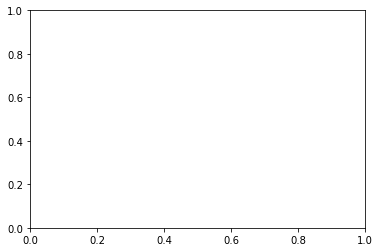

In [22]:
plt.scatter(df_tweets_with_location['lon'],df_tweets_with_location['lat'], s=25)
plt.show()

### Deliverable 4: Scrape for a Search Term

In [ ]:
## PICK A SEARCH TERM AND GATHER TWEETS AROUND MIT

# Input the search term you want to search on
search_term='"fake news"' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[42.360091,-71.096354] # MIT Campus, Cambridge, MA
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=50


# fetch tweets with a given query at a given lat-long
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

## Automate the API

# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 15
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

## Run the Twitter scraper

# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()